In [1]:
from captum.attr import IntegratedGradients, LayerIntegratedGradients
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
from tqdm import tqdm
import os

tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
model = GPT2LMHeadModel.from_pretrained('gpt2-xl', pad_token_id=tokenizer.eos_token_id)
start_text = "Megan Rapinoe plays the sport of"
start_text = "The Big Bang Theory premieres on"


n_steps=50


encoded_input = tokenizer(start_text, return_tensors='pt')
start_length = encoded_input.input_ids.shape[-1]

generated_text_length = 1
max_length = start_length + generated_text_length

generate = model.generate(**encoded_input, max_length=max_length)

encoded_ids = generate

attributions_list = list()

def untuple(x):
    if isinstance(x, tuple):
        return x[0]
    return x
    
def model_forward_wrapper(*args, **kwargs):
    output = model(args[0].long(), **kwargs, return_dict=False)[0]
    return output

#IG = LayerIntegratedGradients(model_forward_wrapper, model.transformer.wte)
IG = LayerIntegratedGradients(model_forward_wrapper, model.transformer.h[15])

def sum_embedding_attributions(attributions):
    return torch.sum(untuple(attributions) ** 2, dim=-1).sqrt().squeeze()

for i in tqdm(range(0, generated_text_length)):
    length = start_length + i
    baseline = torch.tensor([[tokenizer.unk_token_id] * length]).long()
    target = (length - 1, encoded_ids[0, length-1].item())
    input_ids = encoded_ids[:, :length]
    attributions = IG.attribute(
        inputs = input_ids,
        baselines = baseline,
        target = target,
        n_steps = n_steps,
    )
    sum_attr = sum_embedding_attributions(attributions)
    attributions_list.append(sum_attr)

for attribution in attributions_list:
    print(attribution)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.85s/it]

tensor([0.0066, 0.7797, 0.3535, 1.0482, 2.1767, 0.1241, 1.7731],
       dtype=torch.float64)


The 0.006593019076484501
 Big 0.7797055834515826
 Bang 0.3534897389031462
 Theory 1.0481636722259184
 premie 2.1766928142137103
res 0.12409425609007092
 on 1.773079311367257


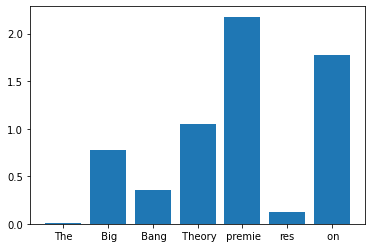

In [2]:
from matplotlib import pyplot as plt

plt.bar([tokenizer.decode(tok) for tok in input_ids[0]], attribution)
for tok, att in zip(input_ids[0], attribution):
    print(tokenizer.decode(tok), att.item())

In [3]:
if False:
    layer_attributions = {}

    for kind in ['', 'mlp', 'attn']:
        layer_attributions[kind] = []
        for layernum in tqdm(range(0, 48)):
            IG = LayerIntegratedGradients(model_forward_wrapper,
                        model.transformer.h[layernum] if not kind
                        else model.transformer.h[layernum].mlp if kind == 'mlp'
                        else model.transformer.h[layernum].mlp.c_fc if kind == 'mlp_fc'
                        else model.transformer.h[layernum].attn)

            length = start_length
            baseline = torch.tensor([[tokenizer.unk_token_id] * length]).long()
            target = (length - 1, encoded_ids[0, length-1].item())
            input_ids = encoded_ids[:, :length]
            attributions = IG.attribute(
                inputs = input_ids,
                baselines = baseline,
                target = target,
                n_steps = n_steps,
            )
            sum_attr = sum_embedding_attributions(attributions)
            layer_attributions[kind].append(sum_attr)


In [5]:
def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None):
    differences = result["scores"]
    low_score = result["low_score"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "mlp_fc": "Blues", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=min(2.0, (differences).max())
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not kind:
            ax.set_title("Layer integrated gradient for hidden state")
            ax.set_xlabel("single layer within GPT-2-XL")
        else:
            kindname = "MLP" if kind == "mlp" else "MLP FC" if kind == "mlp_fc" else "Attn"
            ax.set_title(f"Layer integrated gradient on {kindname} output")
            ax.set_xlabel("single layer within GPT-2-XL")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        cb.ax.set_title(f"||IG||", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

if False:
    for kind in ['', 'mlp', 'attn']: # ['mlp_fc']: #, 
        plot_trace_heatmap(dict(
            scores=torch.stack(layer_attributions[kind]).t(),
            low_score=0,
            kind=kind,
            input_tokens=[tokenizer.decode(tok) for tok in input_ids[0]],
            subject_range=[0,0],
        ))

In [6]:
def run_full_ig_for(start_text):

    n_steps=50


    encoded_input = tokenizer(start_text, return_tensors='pt')
    start_length = encoded_input.input_ids.shape[-1]

    generated_text_length = 1
    max_length = start_length + generated_text_length

    generate = model.generate(**encoded_input, max_length=max_length)

    encoded_ids = generate

    attributions_list = list()

    def untuple(x):
        if isinstance(x, tuple):
            return x[0]
        return x

    def model_forward_wrapper(*args, **kwargs):
        output = model(args[0].long(), **kwargs, return_dict=False)[0]
        return output

    #IG = LayerIntegratedGradients(model_forward_wrapper, model.transformer.wte)
    IG = LayerIntegratedGradients(model_forward_wrapper, model.transformer.h[15])

    def sum_embedding_attributions(attributions):
        return torch.sum(untuple(attributions) ** 2, dim=-1).sqrt().squeeze()

    layer_attributions = {}

    for kind in ['', 'mlp', 'attn']:
        layer_attributions[kind] = []
        for layernum in tqdm(range(0, 48)):
            IG = LayerIntegratedGradients(model_forward_wrapper,
                        model.transformer.h[layernum] if not kind
                        else model.transformer.h[layernum].mlp if kind == 'mlp'
                        else model.transformer.h[layernum].mlp.c_fc if kind == 'mlp_fc'
                        else model.transformer.h[layernum].attn)

            length = start_length
            baseline = torch.tensor([[tokenizer.unk_token_id] * length]).long()
            target = (length - 1, encoded_ids[0, length-1].item())
            input_ids = encoded_ids[:, :length]
            attributions = IG.attribute(
                inputs = input_ids,
                baselines = baseline,
                target = target,
                n_steps = n_steps,
            )
            sum_attr = sum_embedding_attributions(attributions)
            layer_attributions[kind].append(sum_attr)
        savepdf = f'ig_pdf/{start_text.replace(" ", "_")}_{kind}.pdf'
        plot_trace_heatmap(dict(
            scores=torch.stack(layer_attributions[kind]).t(),
            low_score=0,
            kind=kind,
            input_tokens=[tokenizer.decode(tok) for tok in input_ids[0]],
            subject_range=[0,0],
        ), savepdf=savepdf)

In [8]:
for t in [
    'Lexus\'s owner,',
    'NTFS is developed by',
    'Lawrence Tayor professionally plays the sport of',
    'Windows Media Player is developed by',
    'Edmund Neupert, performing on the'
    'Brian De Palma works in the area of',
    'Germaine Greer\'s domain of work is',
    'The headquarter of Zillow is in downtown',
    'Mitsubishi Electric started in the early 1900s as a small company in',
    'Madame de Montesson died in the city of',
]:
    print(t)
    run_full_ig_for(t)


Lexus's owner,


100%|███████████████████████████████████████████████████████████████| 48/48 [02:33<00:00,  3.19s/it]


NTFS is developed by


100%|███████████████████████████████████████████████████████████████| 48/48 [02:58<00:00,  3.71s/it]


Lawrence Tayor professionally plays the sport of


100%|███████████████████████████████████████████████████████████████| 48/48 [03:48<00:00,  4.76s/it]


Windows Media Player is developed by


100%|███████████████████████████████████████████████████████████████| 48/48 [03:02<00:00,  3.80s/it]


Edmund Neupert, performing on theBrian De Palma works in the area of


100%|███████████████████████████████████████████████████████████████| 48/48 [06:47<00:00,  8.49s/it]


Germaine Greer's domain of work is


100%|███████████████████████████████████████████████████████████████| 48/48 [04:13<00:00,  5.29s/it]


The headquarter of Zillow is in downtown


100%|███████████████████████████████████████████████████████████████| 48/48 [04:12<00:00,  5.27s/it]


Mitsubishi Electric started in the early 1900s as a small company in


100%|███████████████████████████████████████████████████████████████| 48/48 [05:43<00:00,  7.15s/it]


Madame de Montesson died in the city of


100%|███████████████████████████████████████████████████████████████| 48/48 [04:15<00:00,  5.32s/it]
